In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!kaggle datasets download -d soumikrakshit/lol-dataset

import zipfile
zip_ref = zipfile.ZipFile('/content/lol-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/lol-dataset
License(s): unknown
 95% 313M/331M [00:04<00:00, 81.4MB/s]
100% 331M/331M [00:04<00:00, 74.1MB/s]


Epoch 1/50
485/485 [==============================] - 15s 9ms/step - loss: 0.1519
Epoch 2/50
485/485 [==============================] - 5s 10ms/step - loss: 0.1362
Epoch 3/50
485/485 [==============================] - 4s 9ms/step - loss: 0.1339
Epoch 4/50
485/485 [==============================] - 4s 8ms/step - loss: 0.1305
Epoch 5/50
485/485 [==============================] - 5s 10ms/step - loss: 0.1268
Epoch 6/50
485/485 [==============================] - 4s 8ms/step - loss: 0.1242
Epoch 7/50
485/485 [==============================] - 4s 8ms/step - loss: 0.1210
Epoch 8/50
485/485 [==============================] - 5s 10ms/step - loss: 0.1206
Epoch 9/50
485/485 [==============================] - 4s 9ms/step - loss: 0.1183
Epoch 10/50
485/485 [==============================] - 4s 8ms/step - loss: 0.1184
Epoch 11/50
485/485 [==============================] - 5s 10ms/step - loss: 0.1179
Epoch 12/50
485/485 [==============================] - 4s 8ms/step - loss: 0.1173
Epoch 13/50
485/485 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


Average PSNR after Unprocess step: 4.95


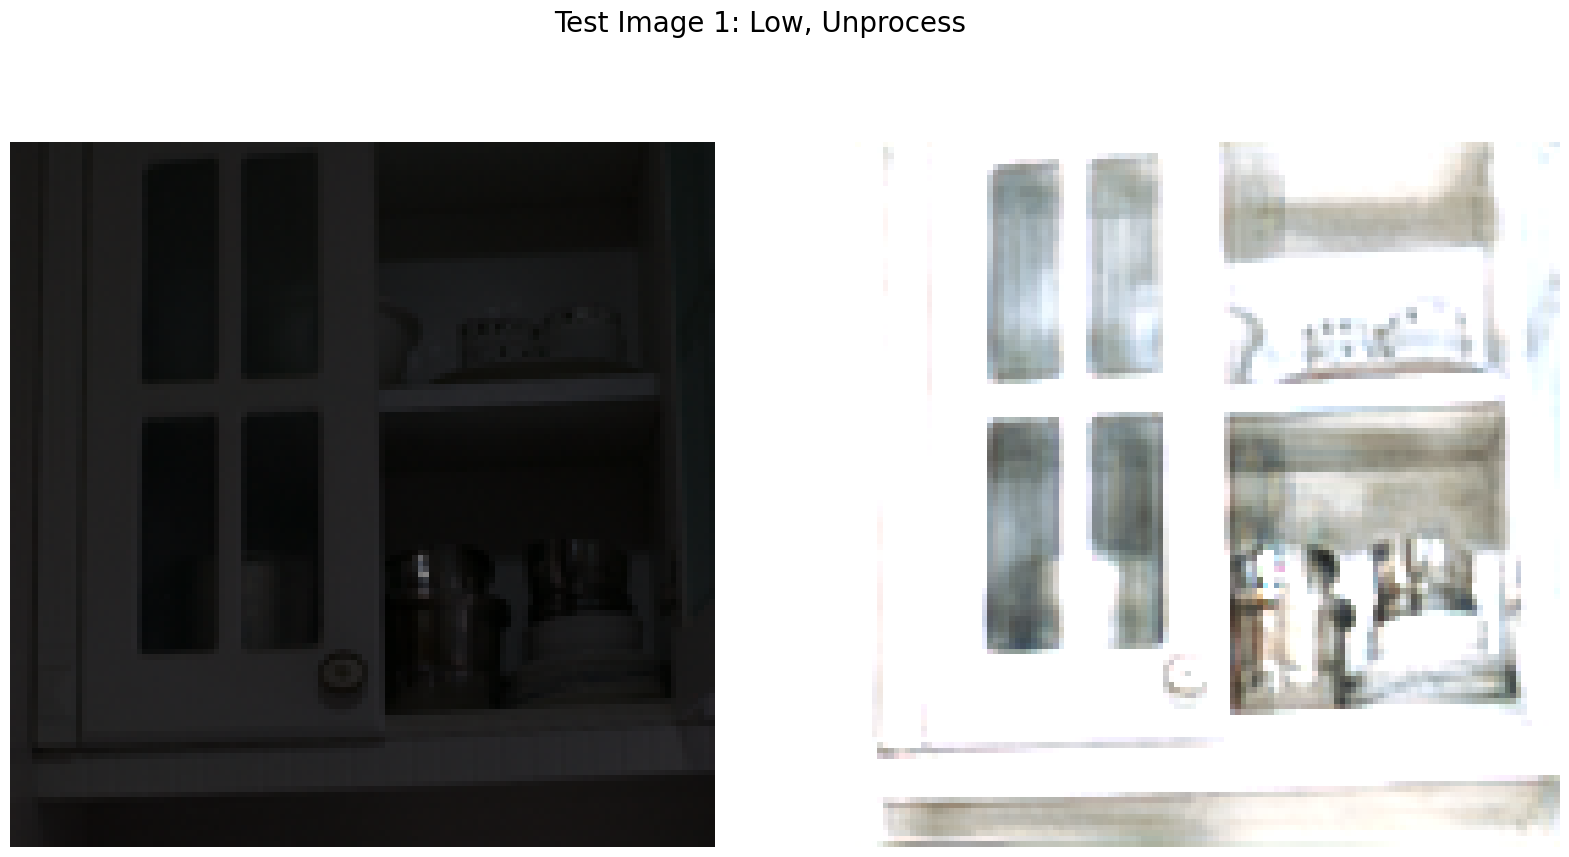

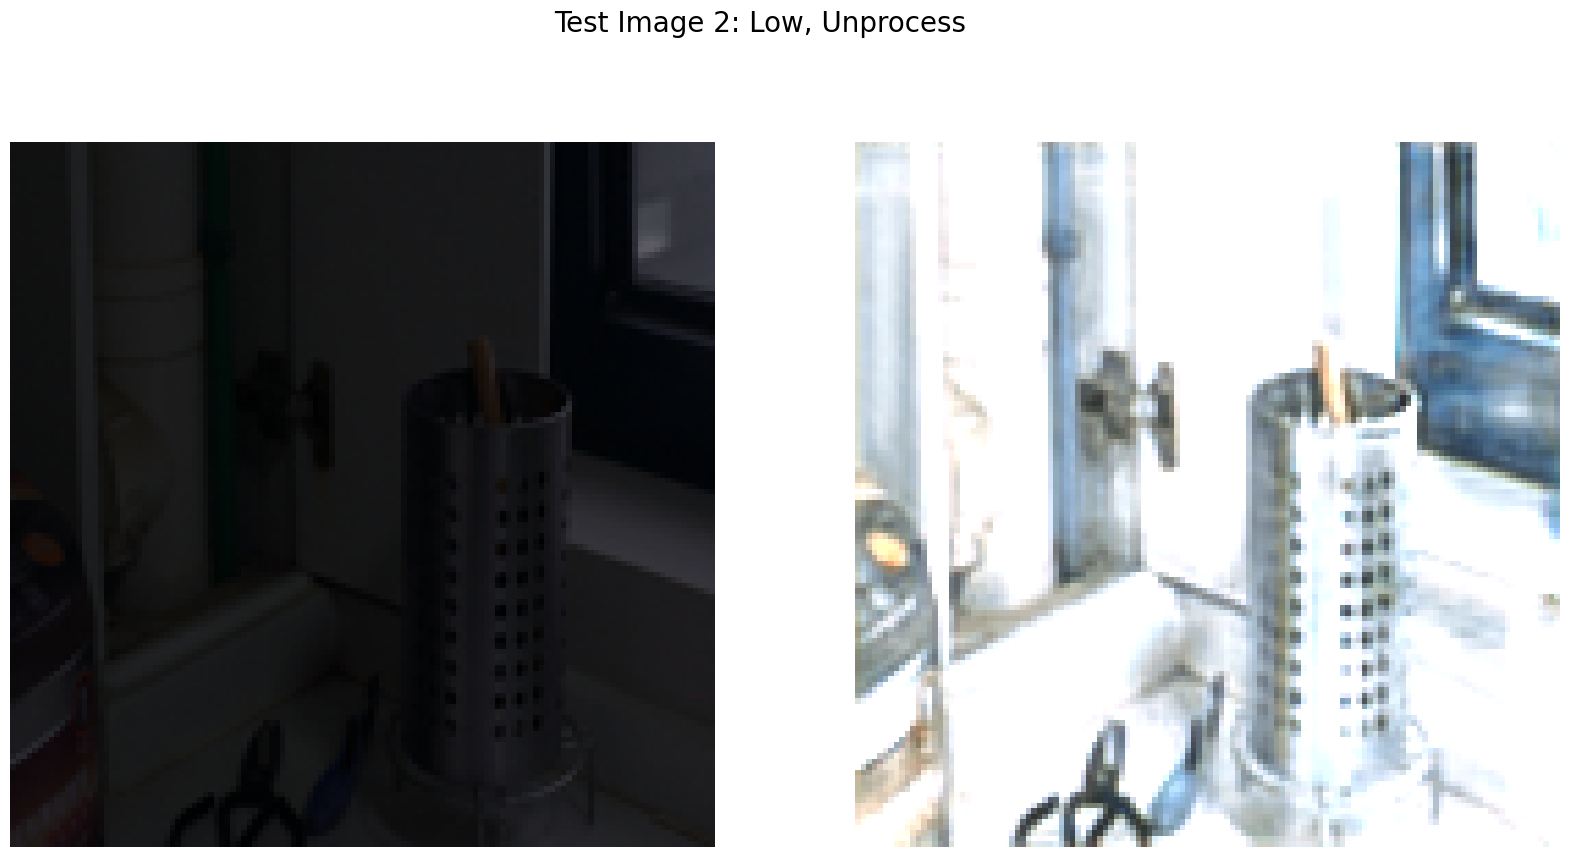

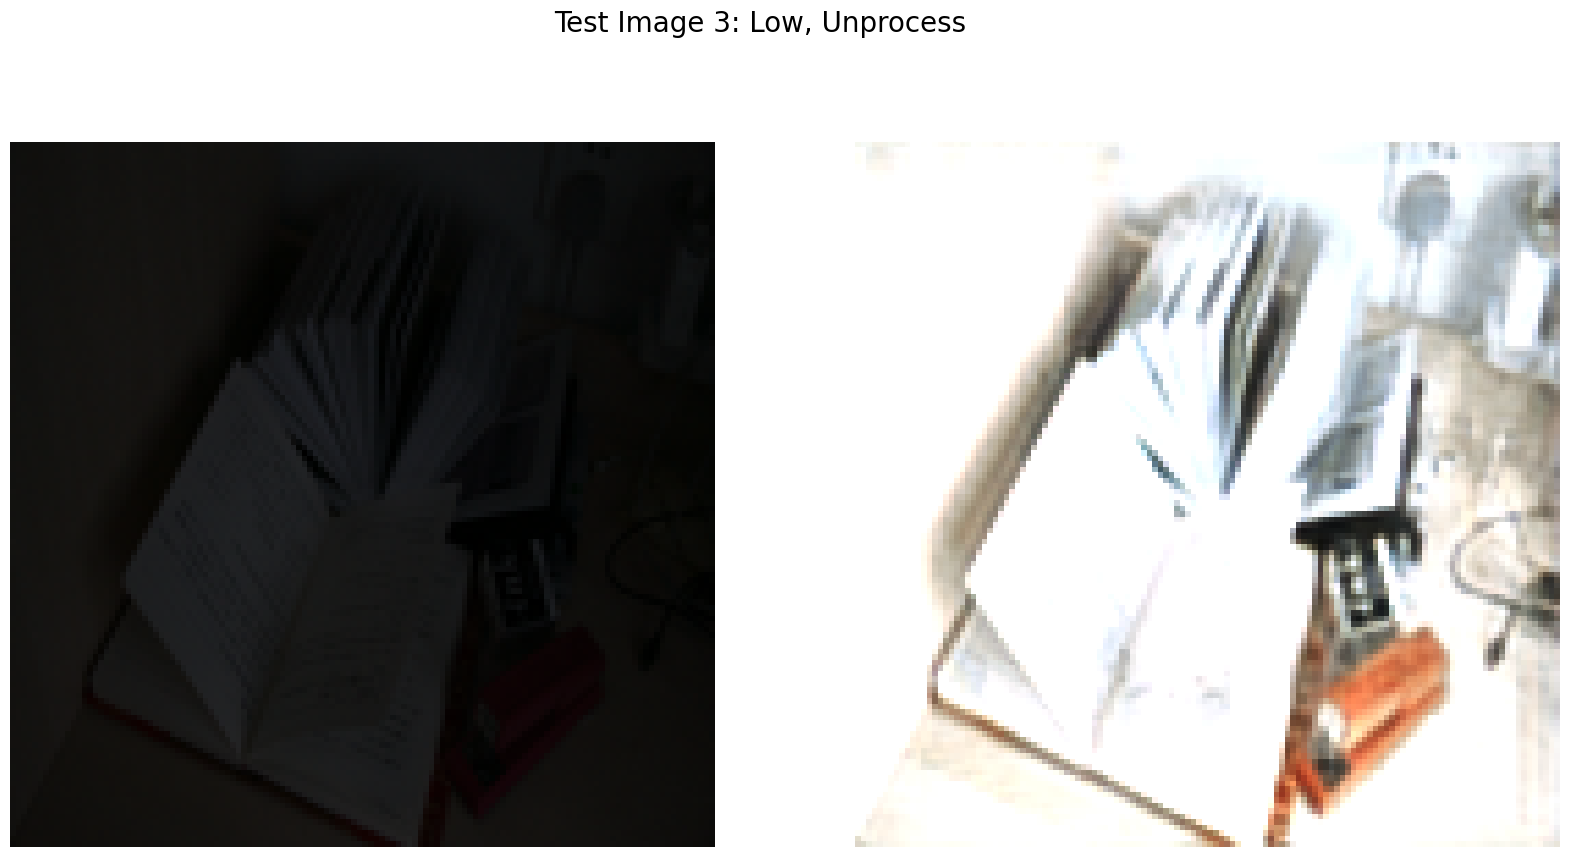

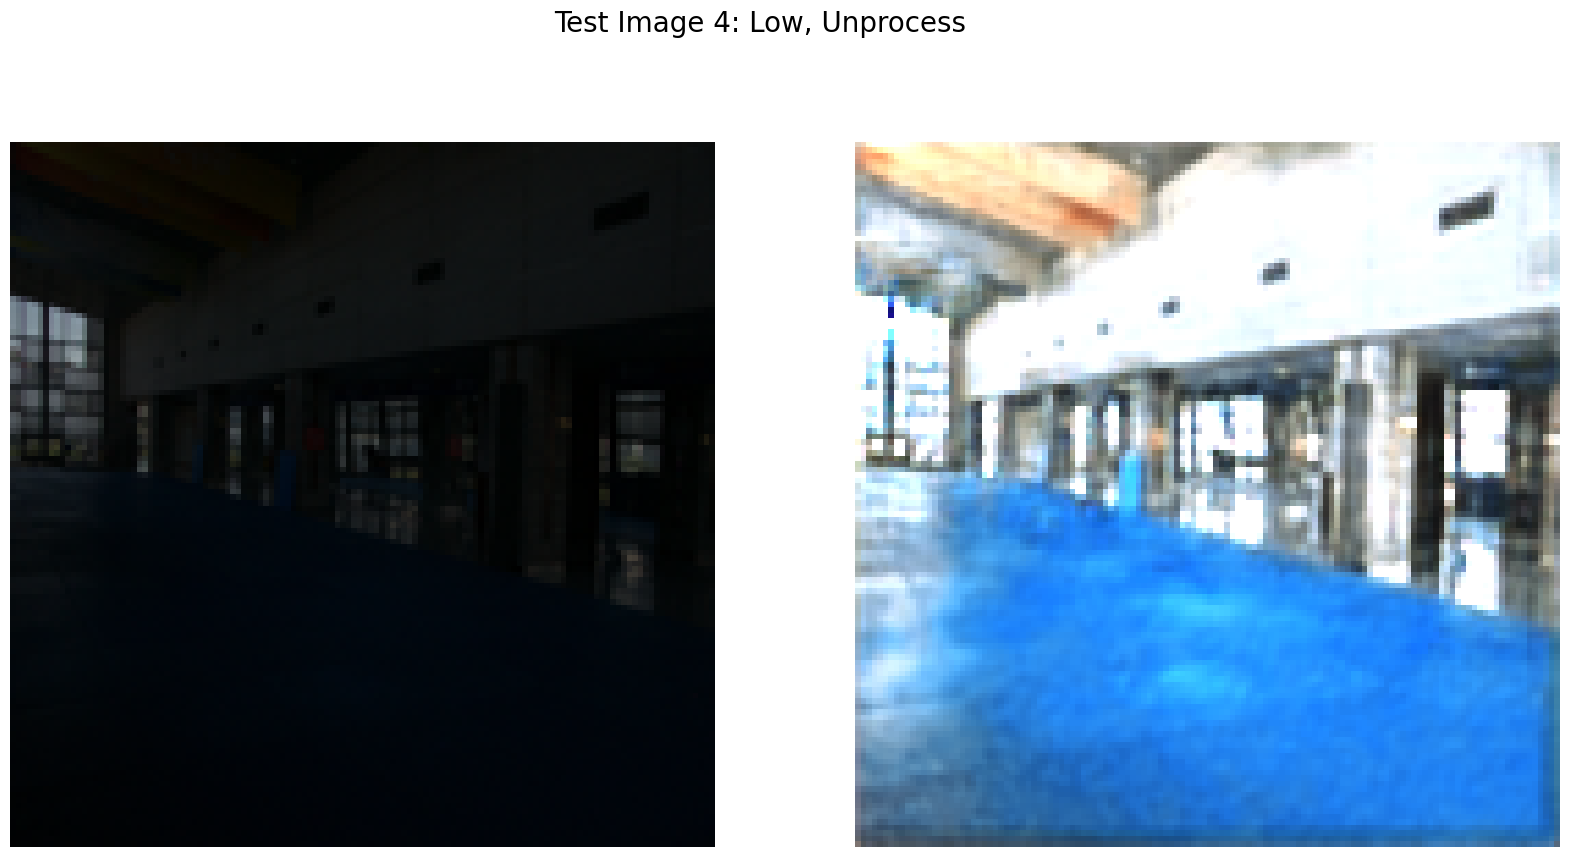

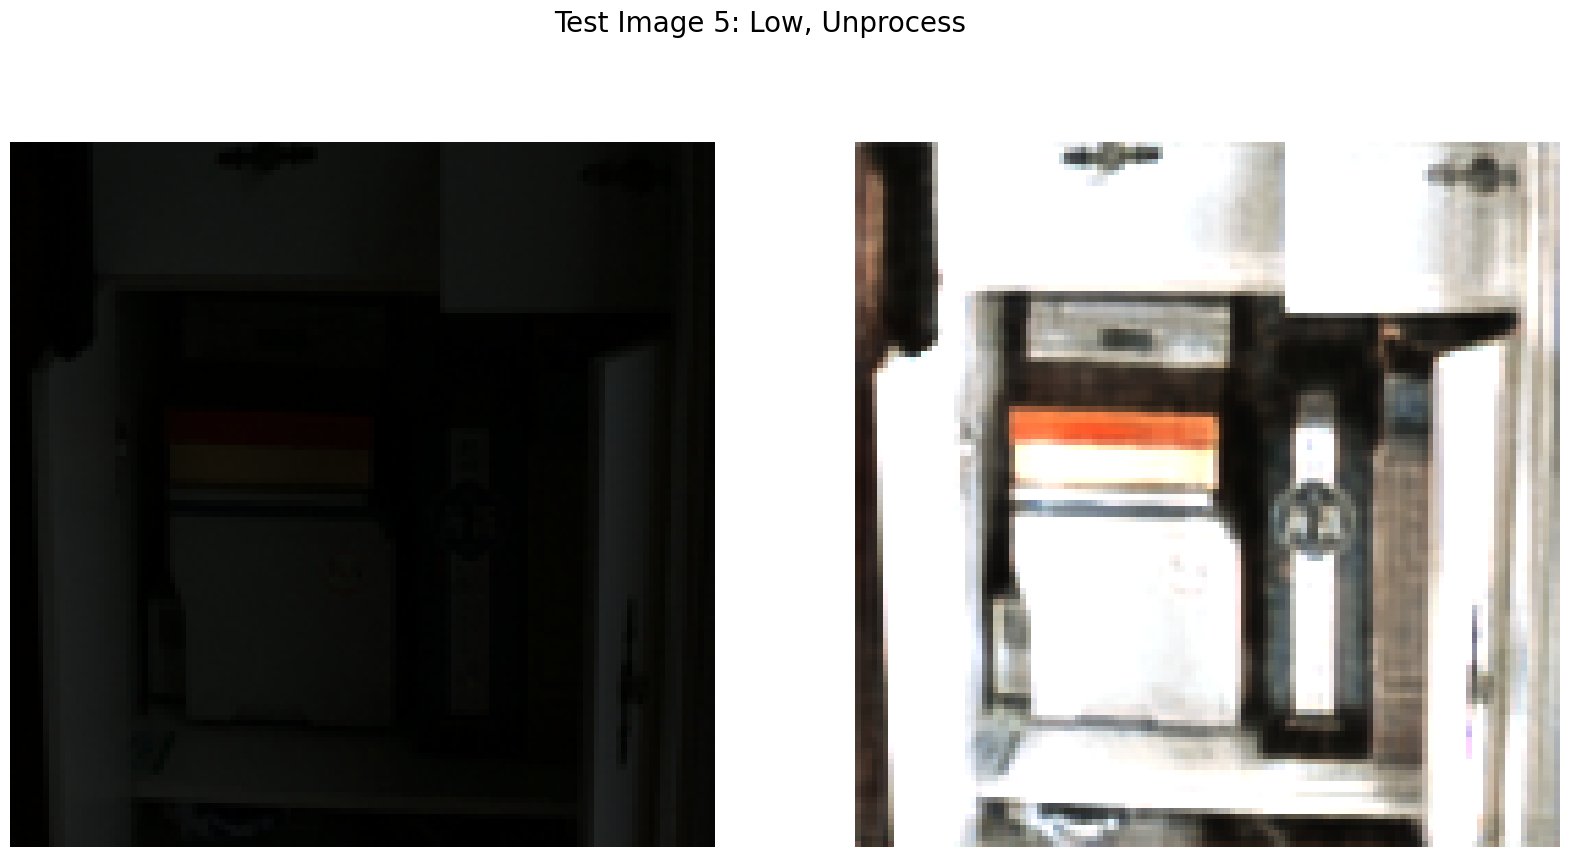

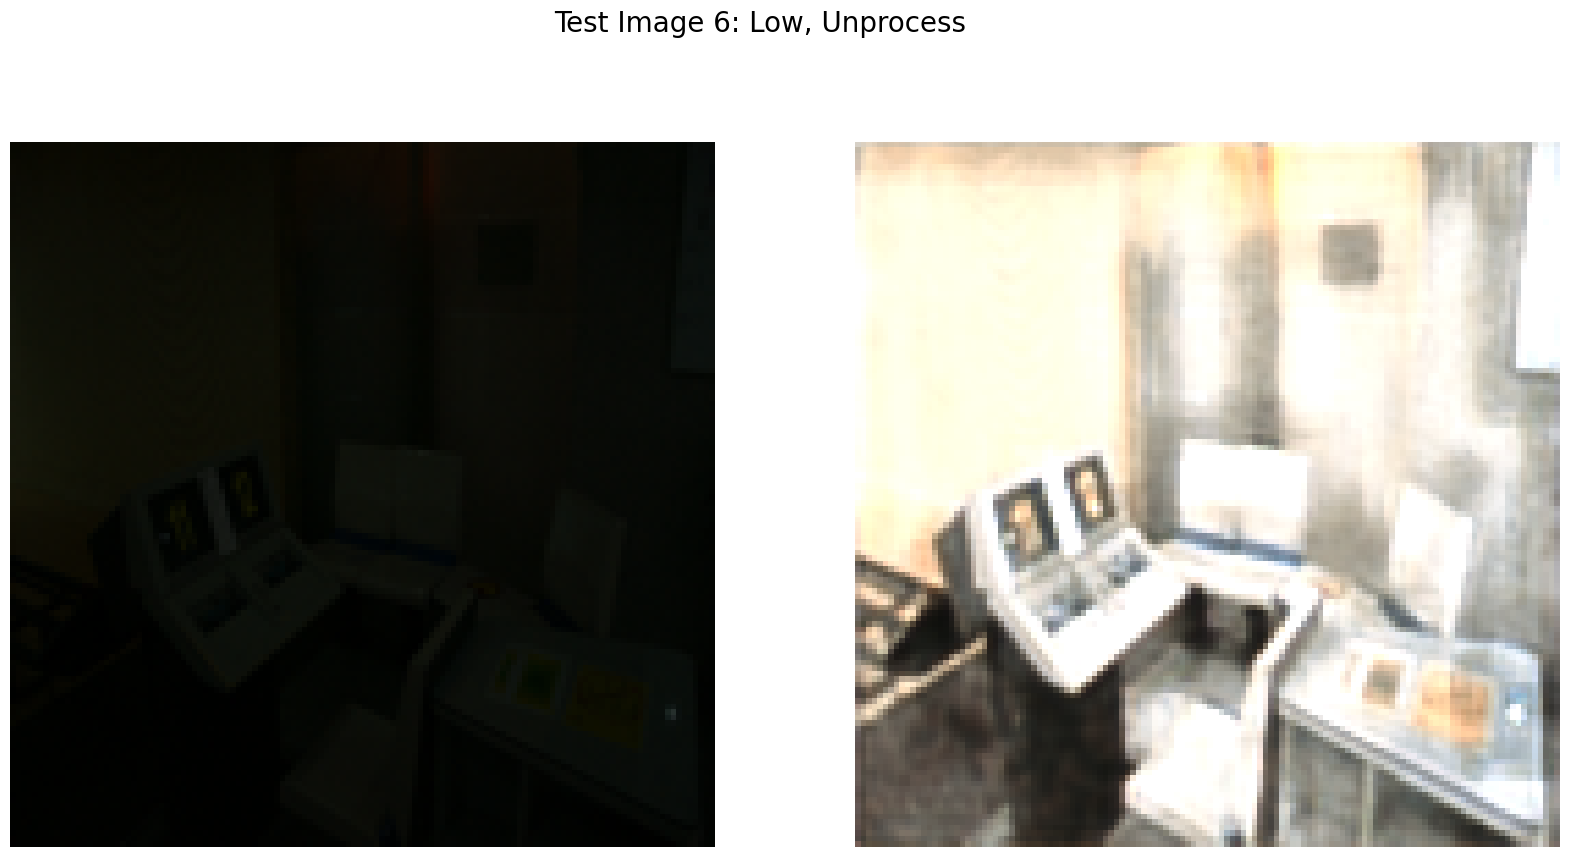

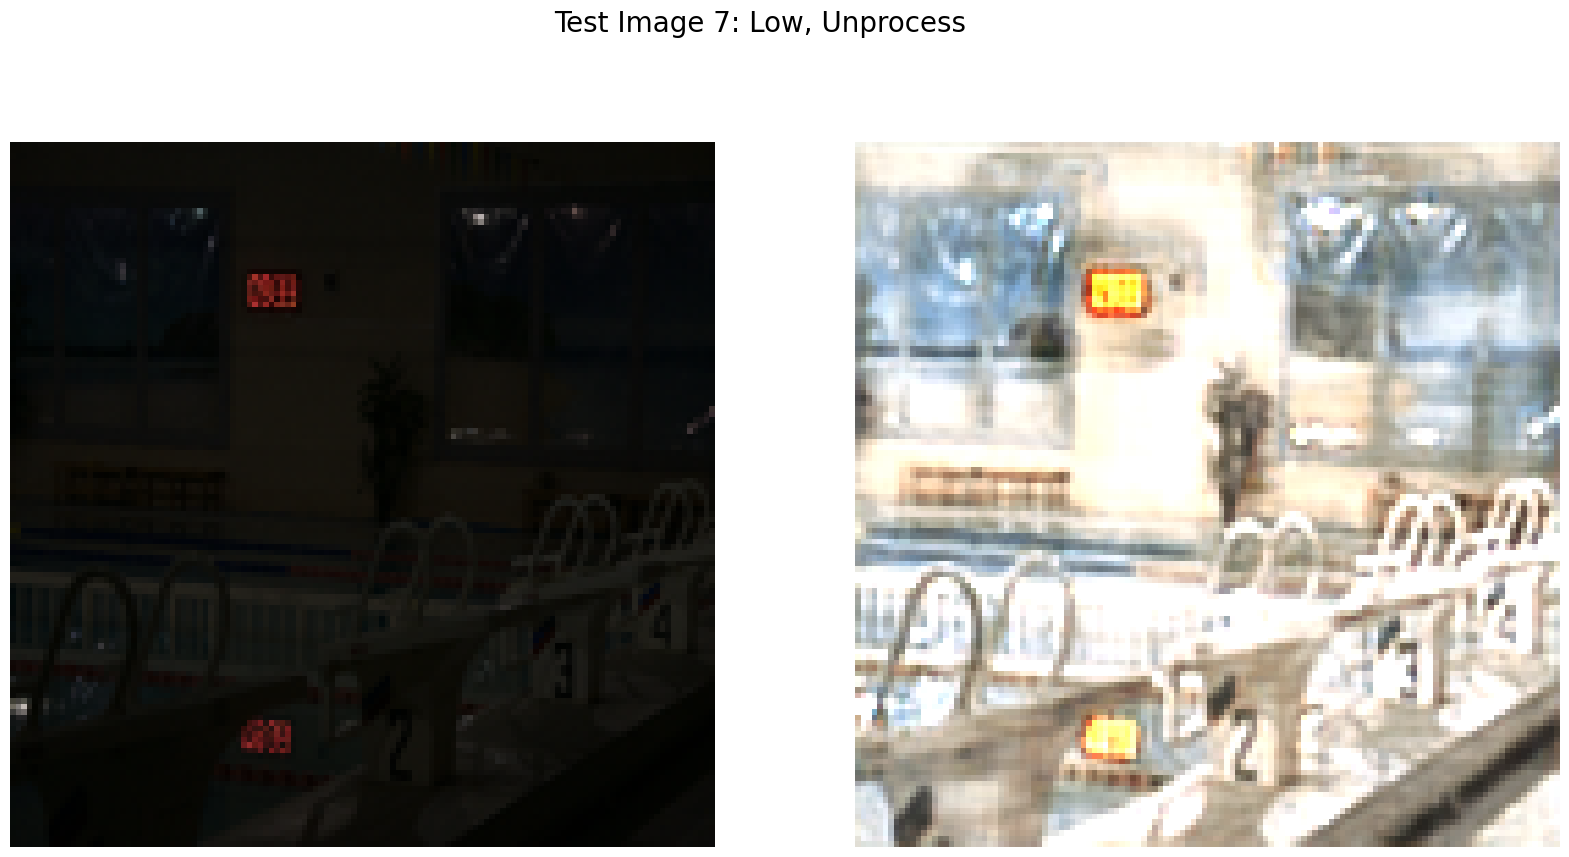

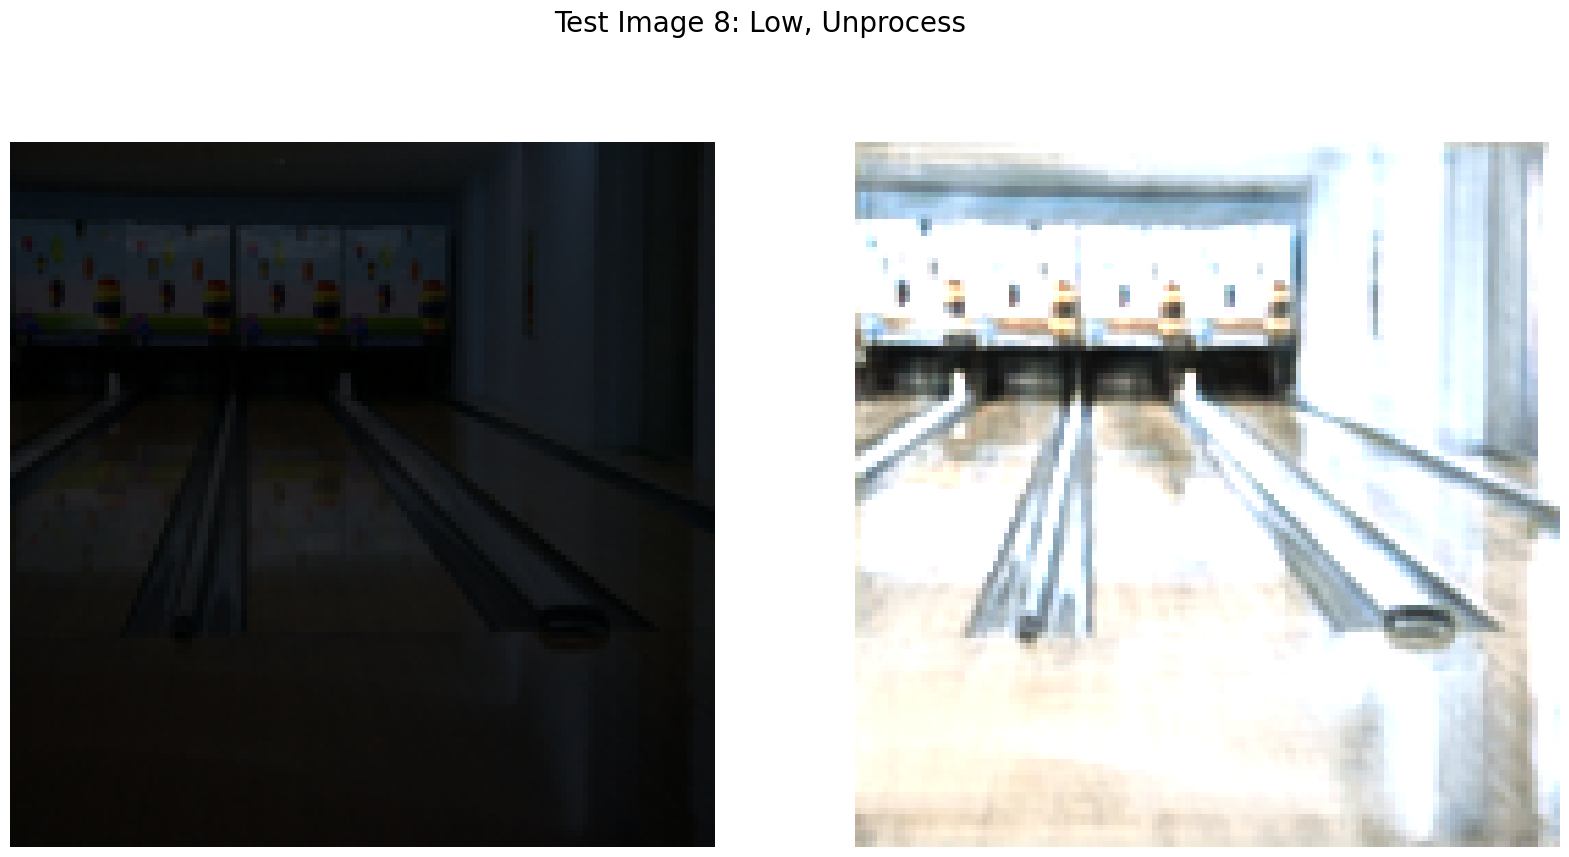

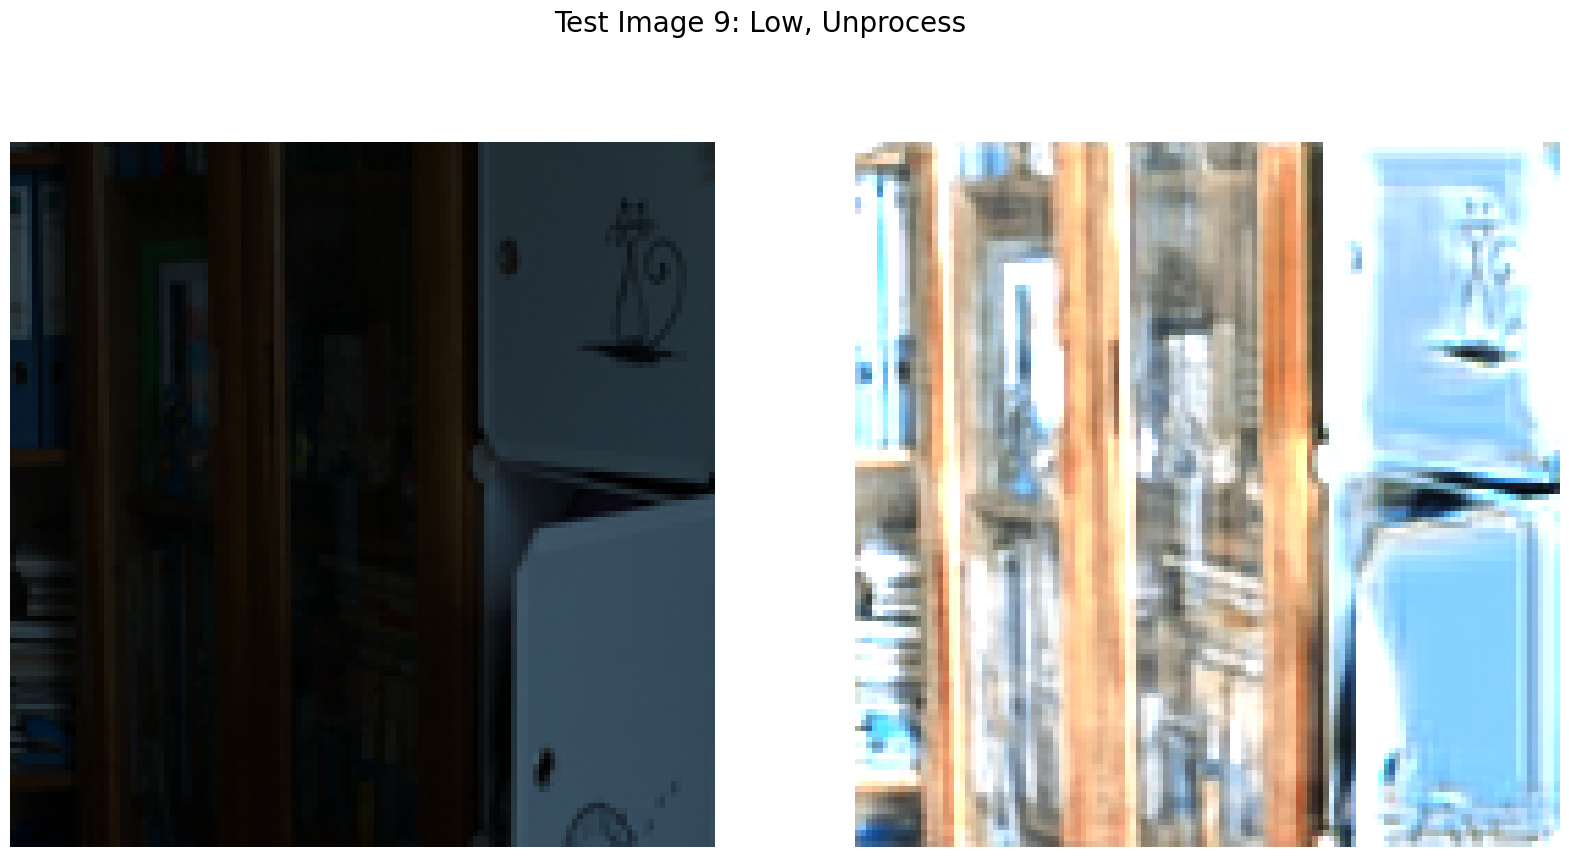

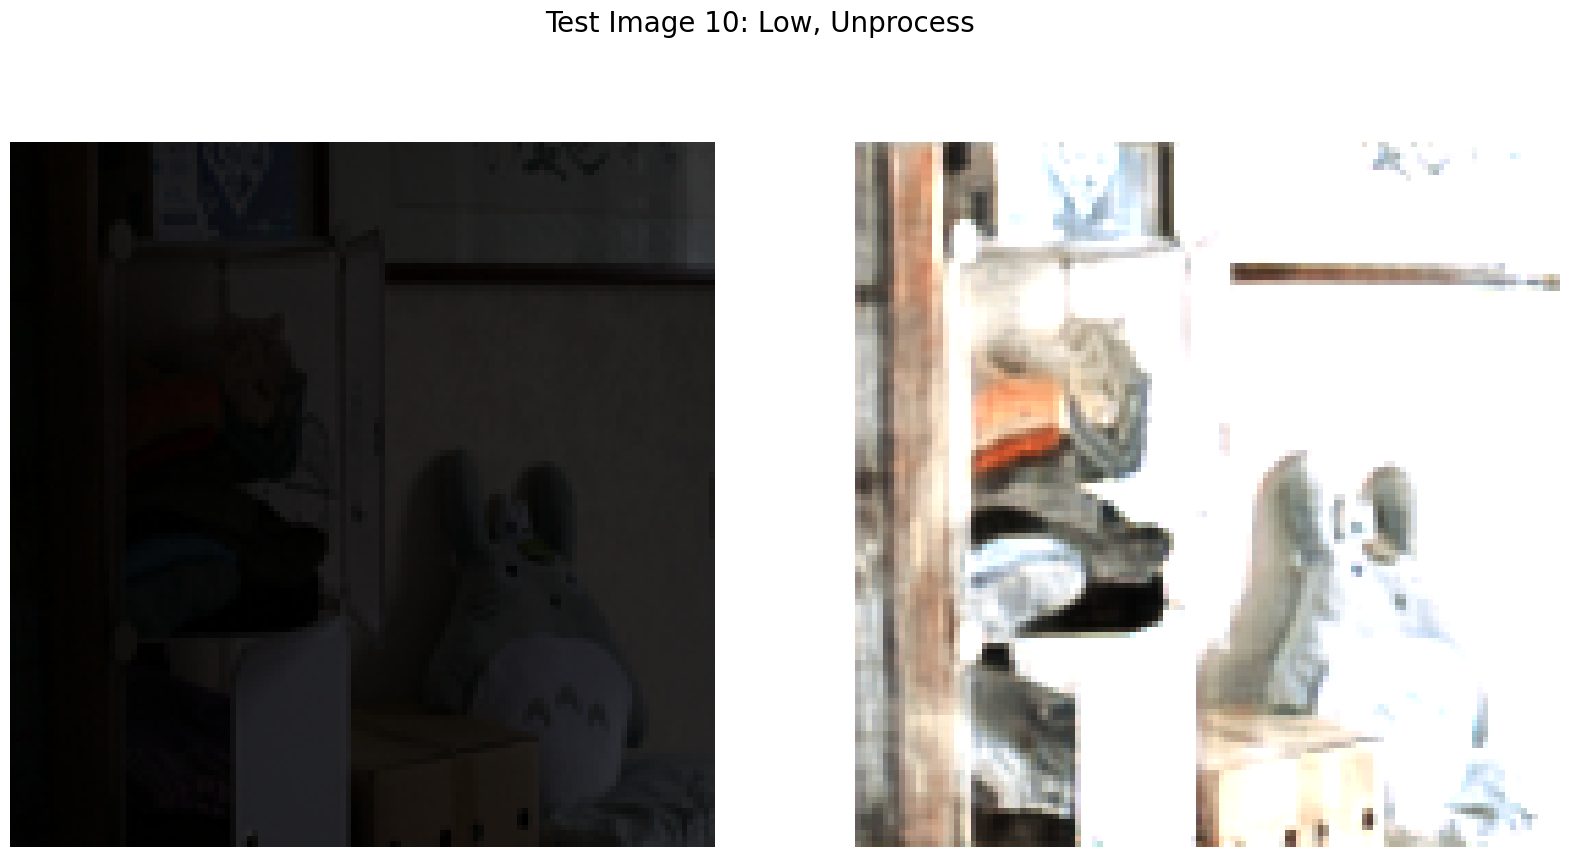

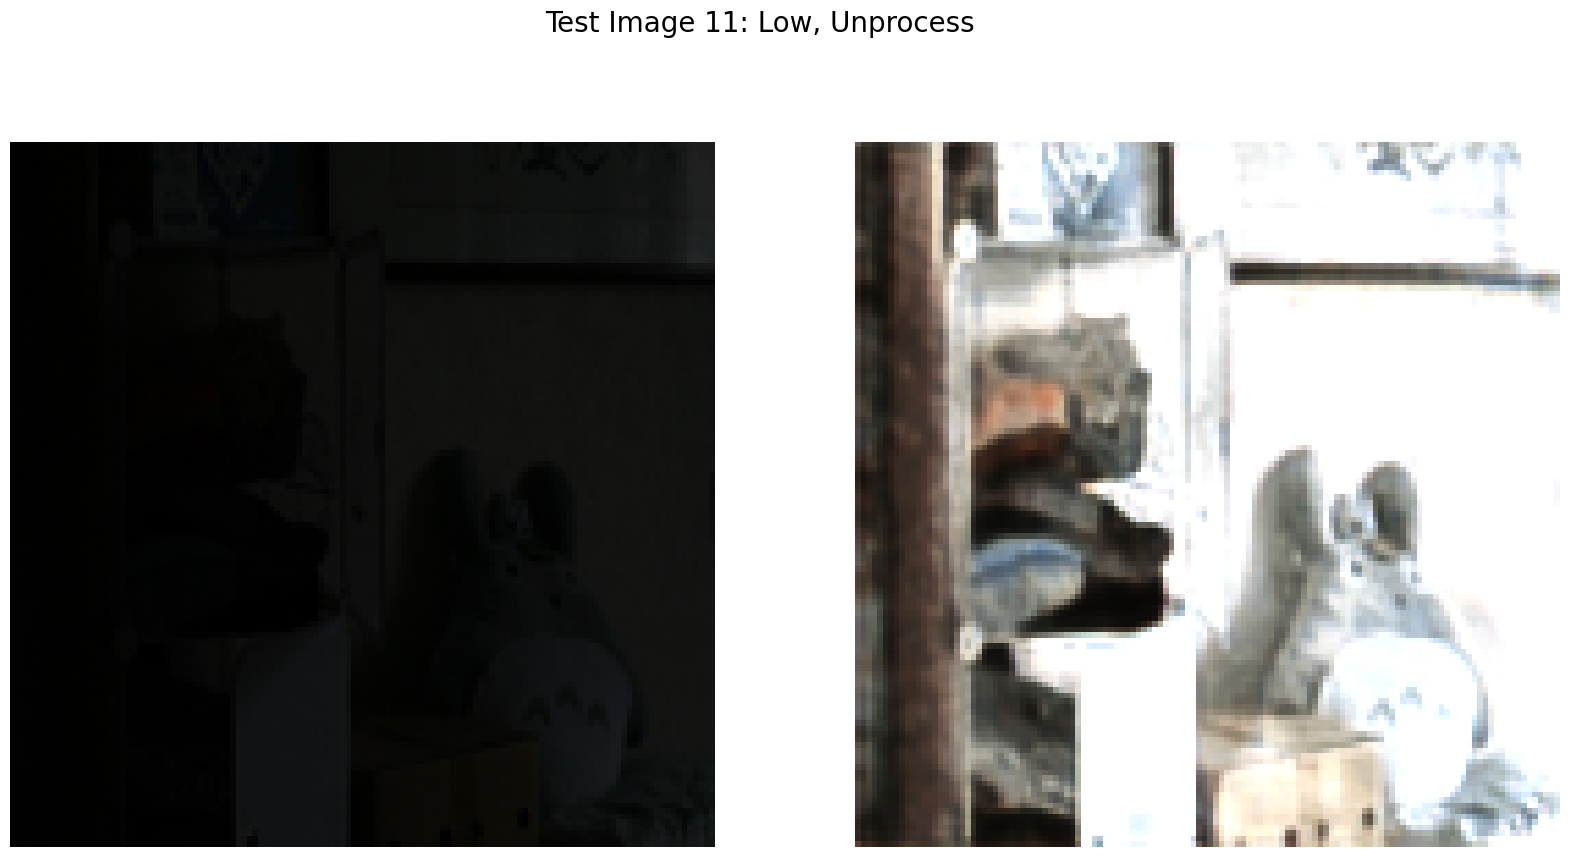

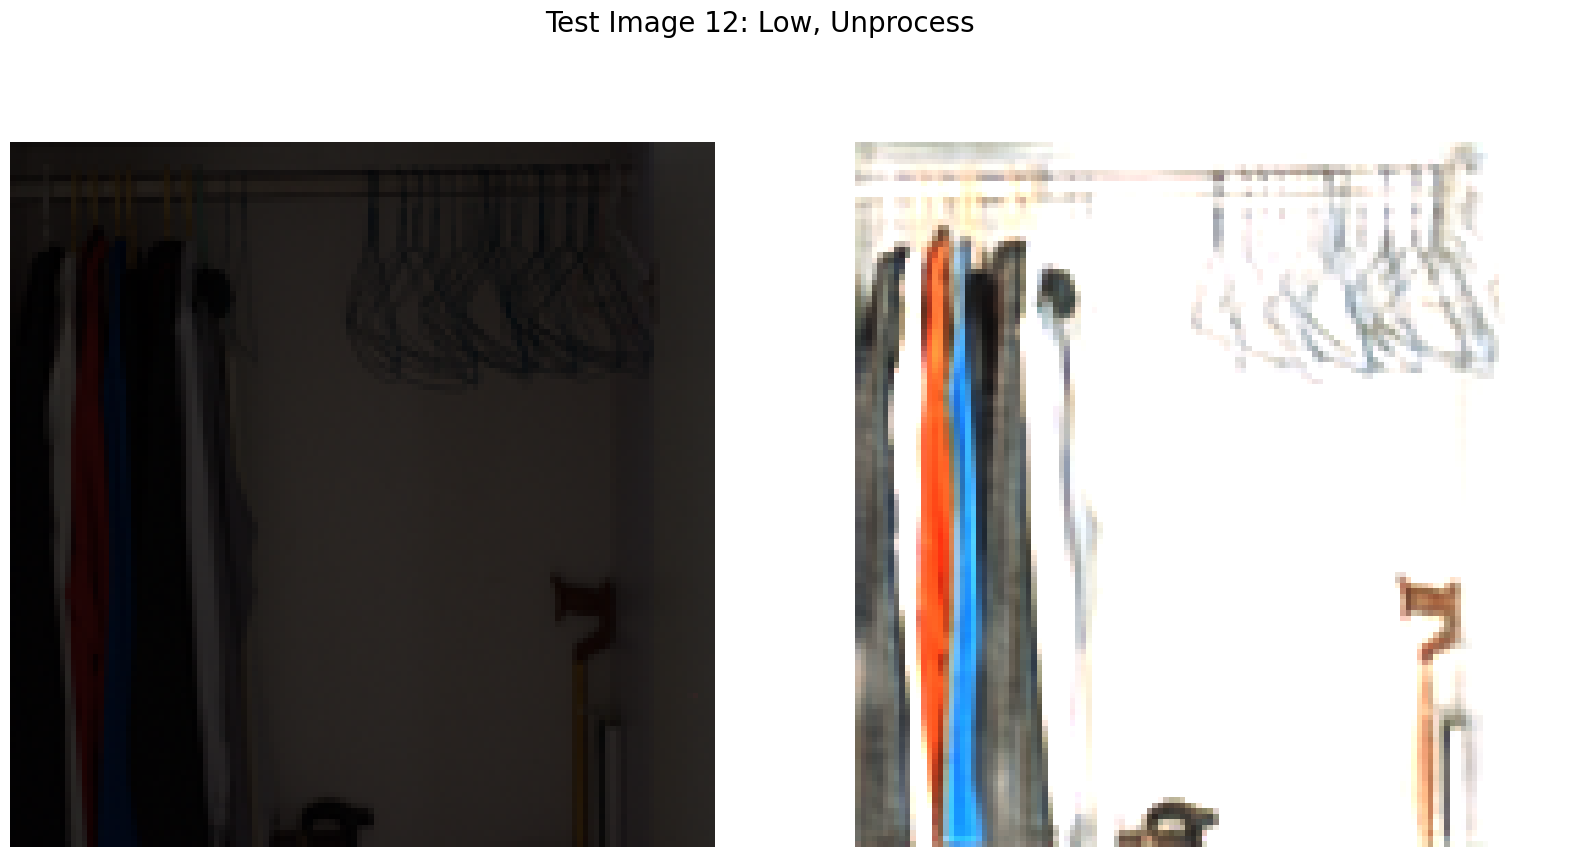

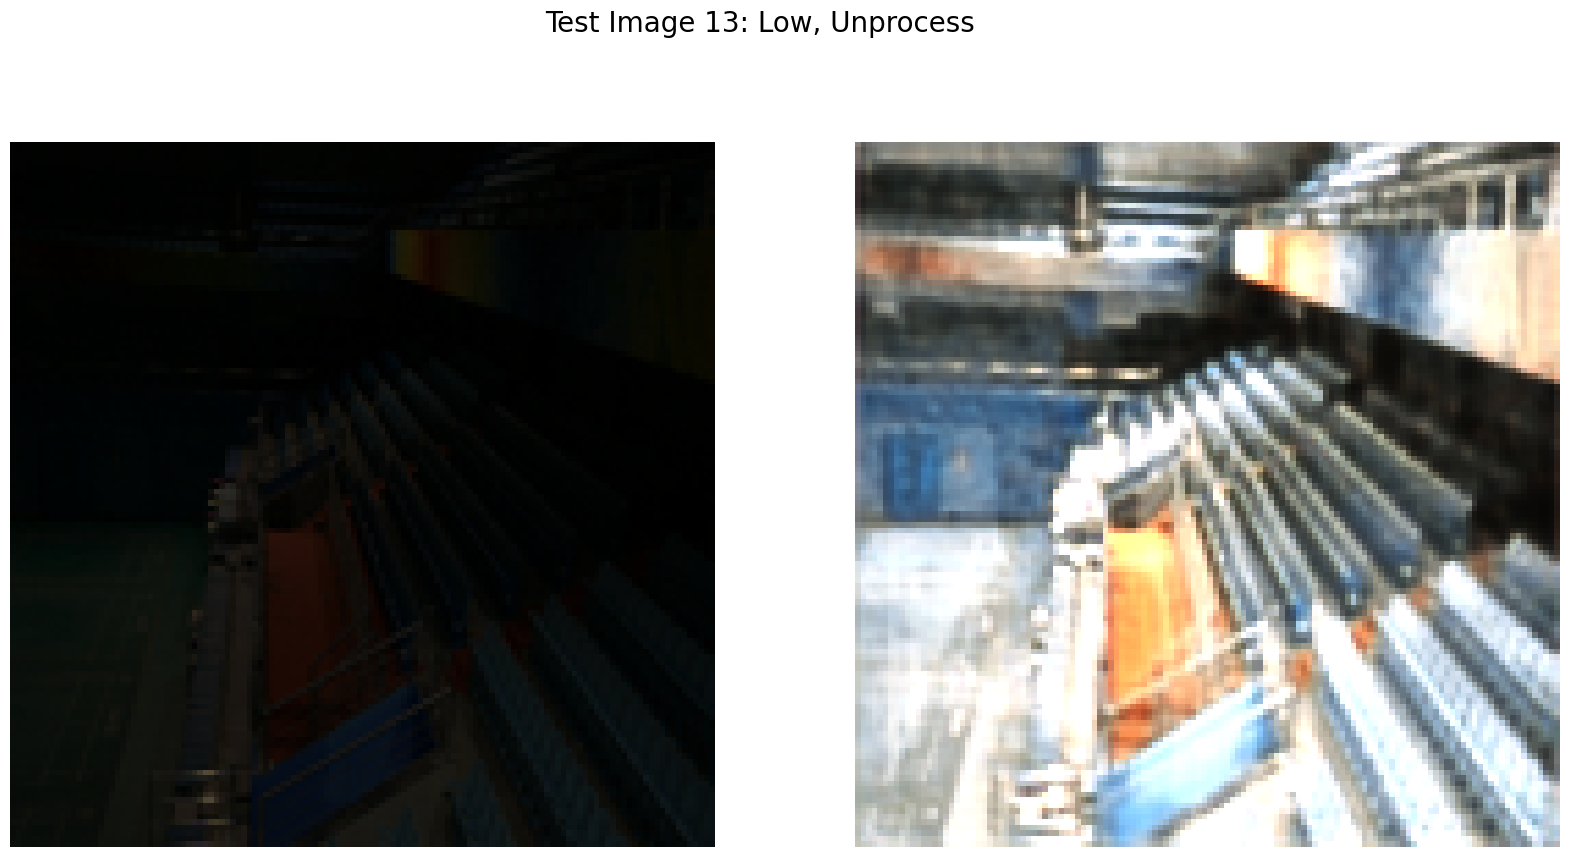

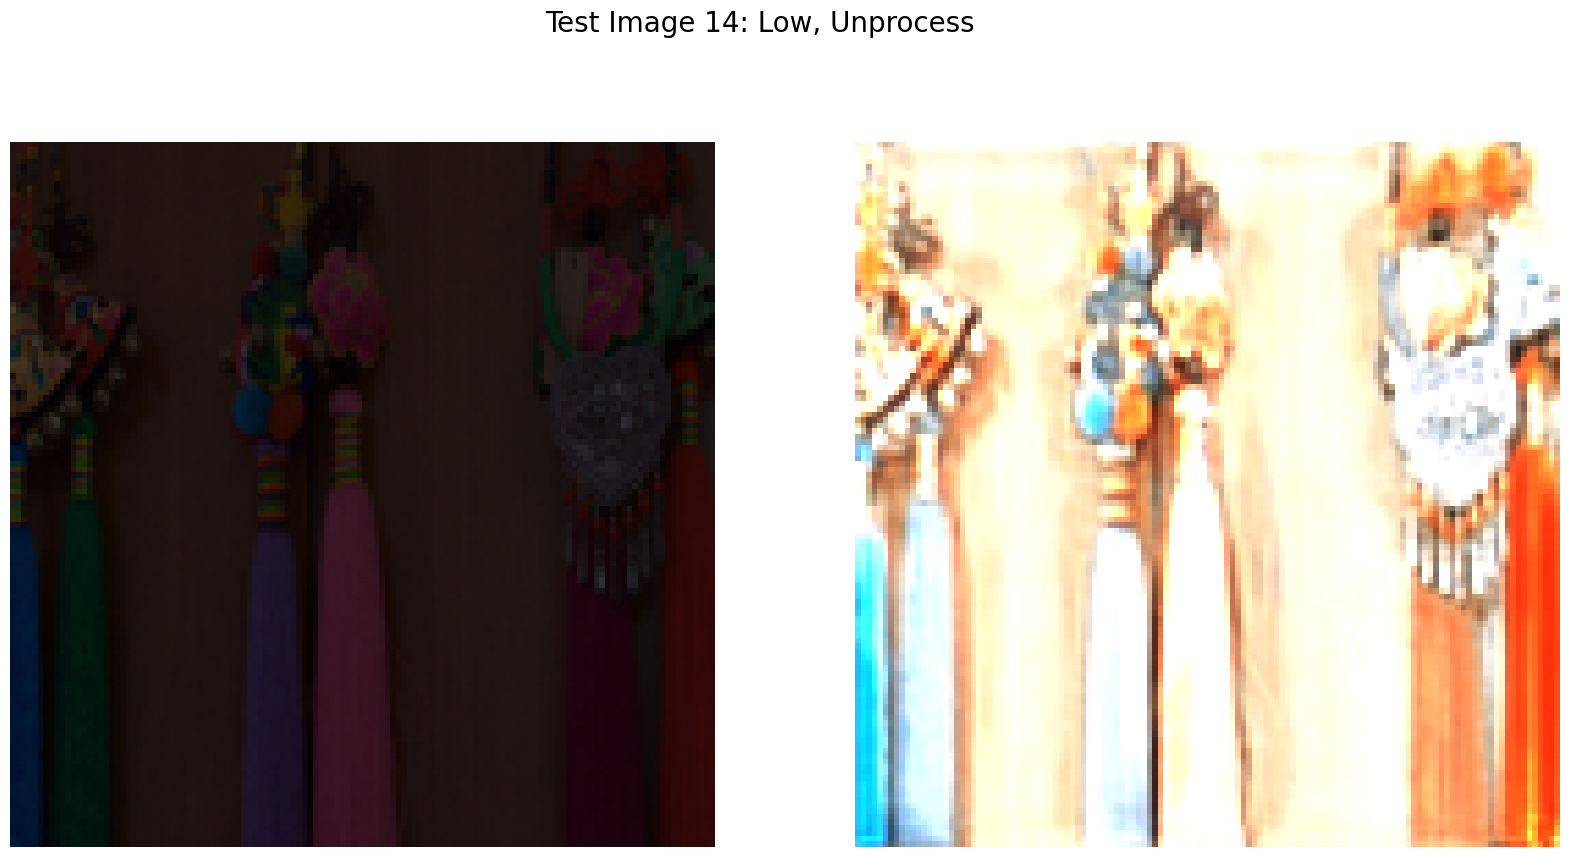

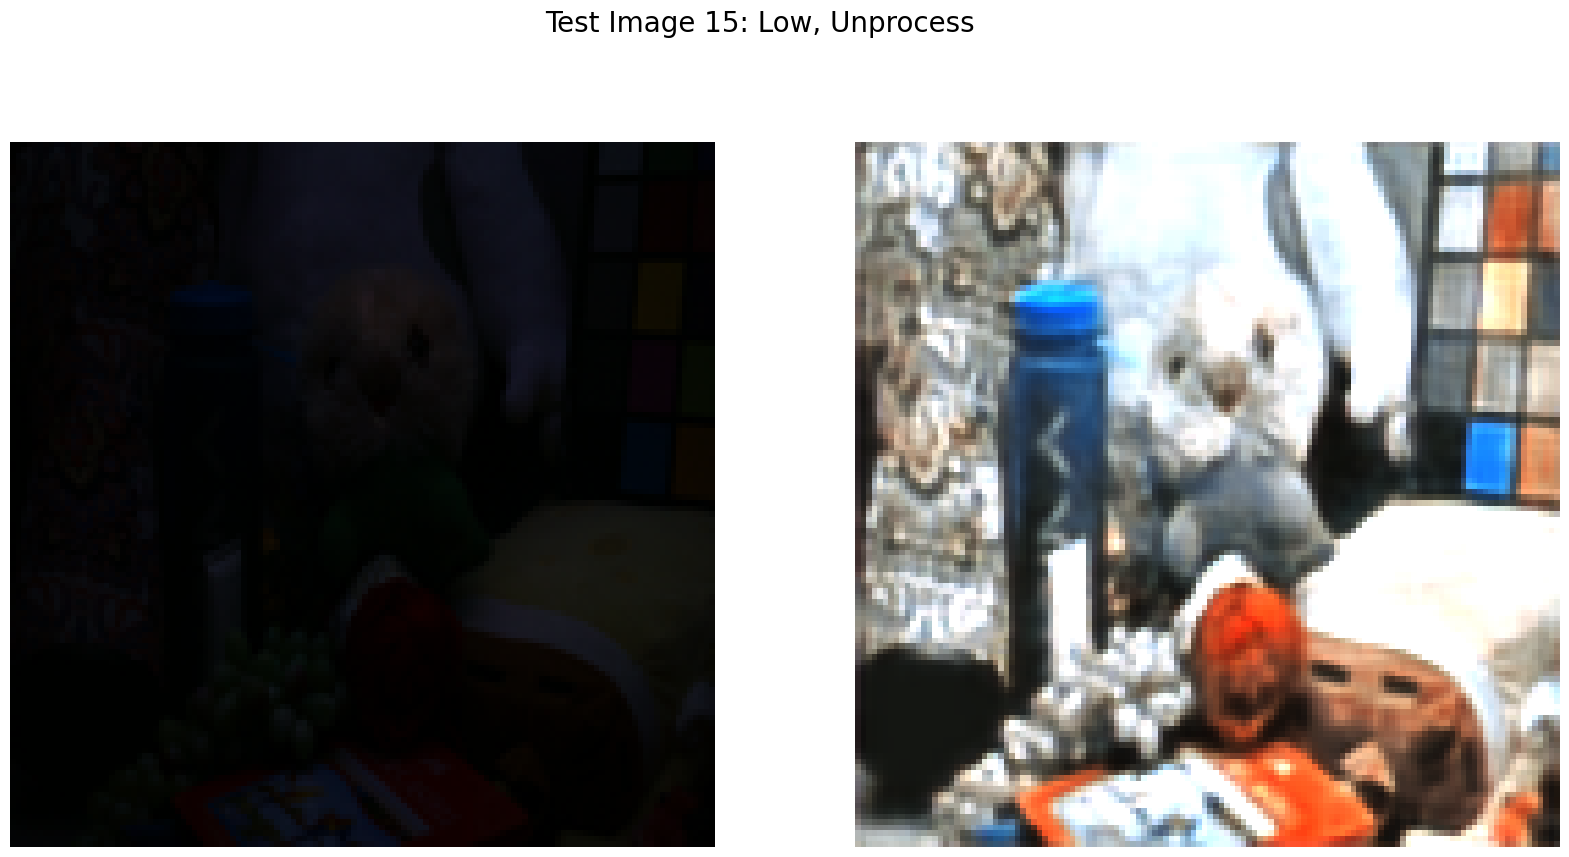

In [ ]:
import os
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Down-sampling
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Up-sampling
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

def load_images(image_paths, target_size=(128, 128)):
    images = []
    for img_path in image_paths:
        img = Image.open(img_path).resize(target_size)
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images)

def calculate_psnr(true_image, predicted_image):
    mse = mean_squared_error(true_image.flatten(), predicted_image.flatten())
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

def display_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    fig.suptitle(title, fontsize=20)
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Load and preprocess the dataset
train_low_paths = glob('lol_dataset/our485/low/*.png')
train_high_paths = glob('lol_dataset/our485/high/*.png')
test_low_paths = glob('lol_dataset/eval15/low/*.png')

train_low_images = load_images(train_low_paths)
train_high_images = load_images(train_high_paths)
test_low_images = load_images(test_low_paths)

# Initialize models
unprocess_model = unet()

# Compile models
unprocess_model.compile(optimizer=Adam(lr=1e-4), loss='mae')

# Training each sub-network
unprocess_model.fit(train_low_images, train_high_images, epochs=50, batch_size=1, verbose=1)

# Joint Training
train_high_linear = unprocess_model.predict(train_low_images) * 1.75

# Save models
unprocess_model.save('unprocess_model.h5')

# Load models
unprocess_model = tf.keras.models.load_model('unprocess_model.h5')

# Predict images at each step
brightened_linear = unprocess_model.predict(test_low_images) * 1.75

# Calculate PSNR
psnr_unprocess = [calculate_psnr(high, bright) for high, bright in zip(train_high_images, brightened_linear)]

avg_psnr_unprocess = np.mean(psnr_unprocess)

print(f'Average PSNR after Unprocess step: {avg_psnr_unprocess:.2f}')

# Display images after each step
for i in range(len(test_low_images)):
    display_images([test_low_images[i], brightened_linear[i]],
                   title=f'Test Image {i+1}: Low, Unprocess')


In [ ]:
# Calculate PSNR
psnr_unprocess = [calculate_psnr(high, bright) for high, bright in zip(test_high_images, brightened_linear)]

avg_psnr_unprocess = np.mean(psnr_unprocess)
print(f'Average PSNR after Unprocess step: {avg_psnr_unprocess:.2f}')
